# Data Preprocessing

In this example, we are creating a data preprocessing pipeline on tabular data containing features for house sales price prediction. A detailed description of the dataset can be found [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

We will start with exploratory data analysis (EDA) on the dataset. As we establish understanding of the dataset by inspecting the raw content, computing statistics, and creating visualizations, we will be incrementally cleaning the dataset to move towards a dataset that can be used for model training. We will save the final version of the cleaned data to a CSV file at "outputs/cleaned_data_housing.csv", which will be used for model training in 02_modeling.ipynb.

We will be using `lineapy` to help us extract the preprocessing pipeline from our work session without us having to retrace our steps to figure out what parts of the notebook were EDA and what parts were transforming the data and thus should be included in the pipeline. We do this by simply adding `import lineapy` in the first cell and then invoking `lineapy.save` on the final CSV file to create a Linea Artifact. Then, we invoke `lineapy.to_pipeline` to create a pipeline out of the Artifact we just saved. In this example, the pipeline we create can be run and scheduled via Apache Airflow. However, we can create other flavors of pipelines by setting the `framework` parameter.

Side note: you can ignore `# NBVAL_*` and safely remove it from the notebook as you go through the example. It is for passing unit tests only, which we do to make sure the examples are always functional as we update the codebase.

In [1]:
# Uncomment the following lines to install the necessary libraries for running this example.
# ! pip install lineapy
# ! pip install pandas
# ! pip install matplotlib
# ! pip install seaborn
# ! pip install sklearn

import lineapy

In [2]:
import pandas as pd
training_data = pd.read_csv("data/ames_train_cleaned.csv")

In [3]:
training_data.head(10)

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice,TotalBathrooms
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,5,2010,WD,Normal,204900,2.0
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,NaN,MnPrv,NaN,0,6,2010,WD,Normal,95300,1.0
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,NaN,NaN,Gar2,12500,6,2010,WD,Normal,181900,1.5
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,NaN,NaN,NaN,0,4,2010,WD,Normal,254100,3.5
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,NaN,MnPrv,NaN,0,3,2010,WD,Normal,199700,2.5
5,6,527105030,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,6,2010,WD,Normal,205300,2.5
6,8,527145080,120,RL,43.0,5005,Pave,NaN,IR1,HLS,...,NaN,NaN,NaN,0,1,2010,WD,Normal,201400,2.0
7,9,527146030,120,RL,39.0,5389,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,3,2010,WD,Normal,246500,3.0
8,12,527165230,20,RL,NaN,7980,Pave,NaN,IR1,Lvl,...,NaN,GdPrv,Shed,500,3,2010,WD,Normal,174900,3.0
9,13,527166040,60,RL,63.0,8402,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,5,2010,WD,Normal,170300,2.5


In [4]:
training_data.shape

(1998, 83)

In [5]:
training_data.columns

Index(['Order', 'PID', 'MS_SubClass', 'MS_Zoning', 'Lot_Frontage', 'Lot_Area',
       'Street', 'Alley', 'Lot_Shape', 'Land_Contour', 'Utilities',
       'Lot_Config', 'Land_Slope', 'Neighborhood', 'Condition_1',
       'Condition_2', 'Bldg_Type', 'House_Style', 'Overall_Qual',
       'Overall_Cond', 'Year_Built', 'Year_Remod/Add', 'Roof_Style',
       'Roof_Matl', 'Exterior_1st', 'Exterior_2nd', 'Mas_Vnr_Type',
       'Mas_Vnr_Area', 'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual',
       'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_SF_1',
       'BsmtFin_Type_2', 'BsmtFin_SF_2', 'Bsmt_Unf_SF', 'Total_Bsmt_SF',
       'Heating', 'Heating_QC', 'Central_Air', 'Electrical', '1st_Flr_SF',
       '2nd_Flr_SF', 'Low_Qual_Fin_SF', 'Gr_Liv_Area', 'Bsmt_Full_Bath',
       'Bsmt_Half_Bath', 'Full_Bath', 'Half_Bath', 'Bedroom_AbvGr',
       'Kitchen_AbvGr', 'Kitchen_Qual', 'TotRms_AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace_Qu', 'Garage_Type', 'Garage_Yr_Blt',
      

## Remove columns with > 80% values missing

In [6]:
columns_to_drop = training_data.columns[training_data.isnull().sum() / training_data.shape[0] > .8]
columns_to_drop

Index(['Alley', 'Pool_QC', 'Fence', 'Misc_Feature'], dtype='object')

These columns are mostly missing data, so let's remove them from the dataset.

In [7]:
training_data = training_data.drop(columns_to_drop, axis=1)
training_data.shape

(1998, 79)

## Feature Group 1: Ratios of Square Footage Features

We start by plotting the relationship between different square footage features

In [8]:
# %matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

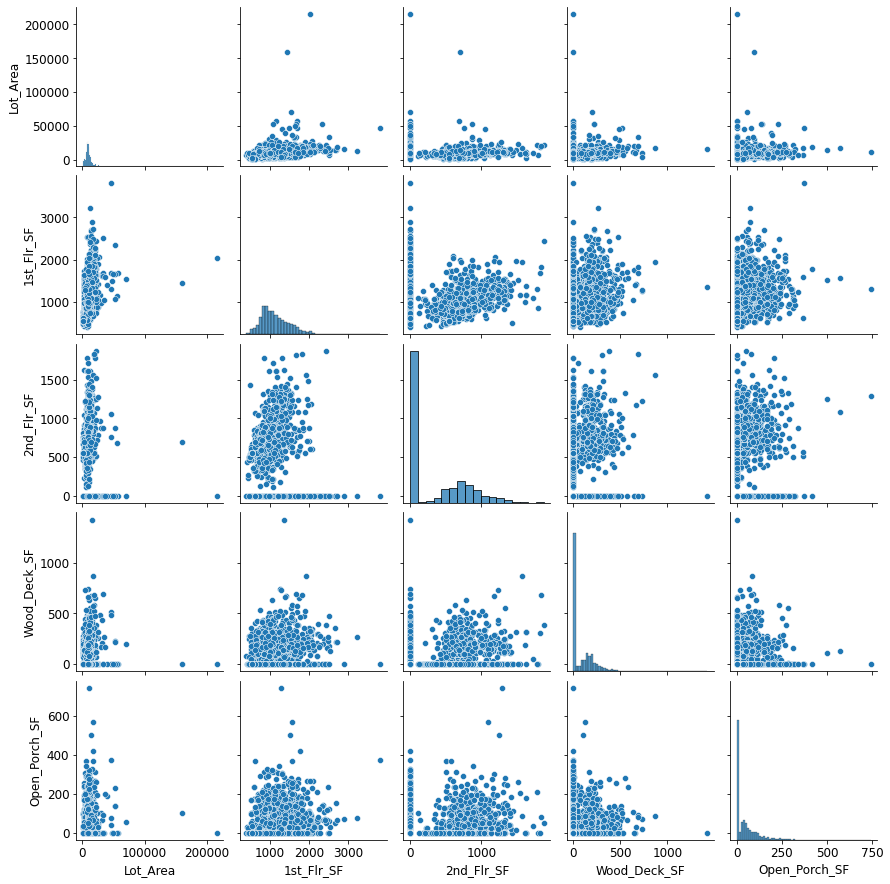

In [9]:
# NBVAL_IGNORE_OUTPUT
sf_features = ['Lot_Area', '1st_Flr_SF', '2nd_Flr_SF', 'Wood_Deck_SF', 'Open_Porch_SF']
sns.pairplot(training_data[sf_features])

From the chart above, we have identified the following relationships as features to be inserted into the training data,

- Lot_Area : 1st_Flr_SF
- 1st_Flr_SF : 2nd_Flr_SF
- Wood_Deck_SF : 2nd_Flr_SF

In addition, we will remove `1st_Flr_SF` and `2nd_Flr_SF` to avoid issues associated with correlated features.

In [10]:
import numpy as np
training_data['LA_v_1st'] = training_data['Lot_Area'] / training_data['1st_Flr_SF']
training_data['1st_v_2nd'] = np.where(training_data['2nd_Flr_SF'] > 0, training_data['1st_Flr_SF'] / training_data['2nd_Flr_SF'], 0)
training_data['wd_v_2nd'] = np.where(training_data['2nd_Flr_SF'] > 0, training_data['Wood_Deck_SF'] / training_data['2nd_Flr_SF'], 0)
training_data = training_data.drop(['1st_Flr_SF', '2nd_Flr_SF'], axis=1)

## `basement_value` feature

The `basement_value` feature involves combining all the individual basement features to create a categorical feature with the values 1 for high-value and 0 for low-value.

First, let's find all the features related to basements.

In [11]:
basement_features = [x for x in training_data.columns if 'bsmt' in x.lower()]
basement_features

['Bsmt_Qual',
 'Bsmt_Cond',
 'Bsmt_Exposure',
 'BsmtFin_Type_1',
 'BsmtFin_SF_1',
 'BsmtFin_Type_2',
 'BsmtFin_SF_2',
 'Bsmt_Unf_SF',
 'Total_Bsmt_SF',
 'Bsmt_Full_Bath',
 'Bsmt_Half_Bath']

In [12]:
training_data[basement_features]

,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,Bsmt_Full_Bath,Bsmt_Half_Bath
0,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,1.0,0.0
1,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,0.0,0.0
2,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,0.0,0.0
3,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,1.0,0.0
4,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1993,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,1.0,0.0
1994,TA,TA,Av,GLQ,819.0,Unf,0.0,184.0,1003.0,1.0,0.0
1995,Gd,TA,Av,BLQ,301.0,ALQ,324.0,239.0,864.0,1.0,0.0
1996,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,0.0,1.0


We see that some of the features are numeric while others are categorical, which should be handled differently.

In [13]:
basement_numeric = ['BsmtFin_SF_1', 'BsmtFin_SF_2', 'Bsmt_Unf_SF', 'Total_Bsmt_SF']
basement_categorical = ['Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2']

Let's first take a look at the relationship between the numeric features

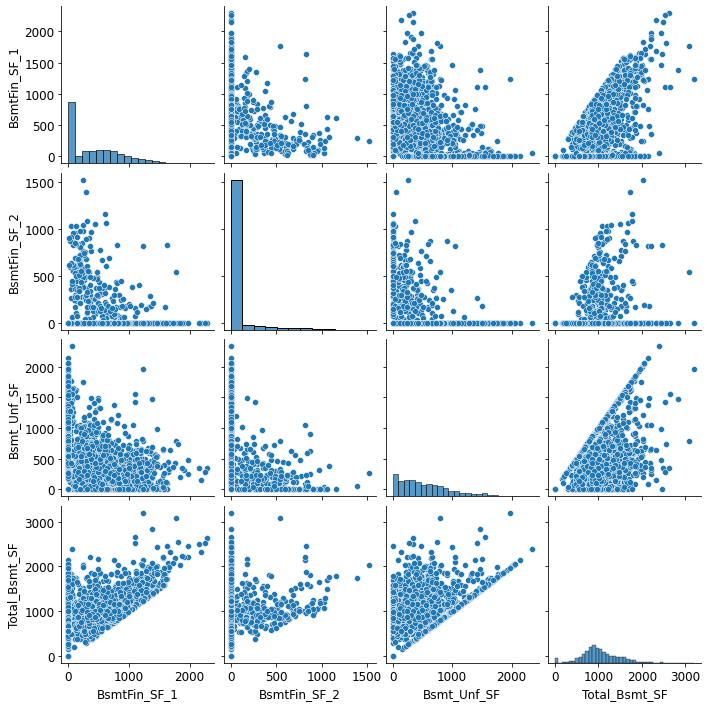

In [14]:
# NBVAL_IGNORE_OUTPUT
sns.pairplot(training_data[basement_numeric])

Let's now look at the distribution of the categorical features

Text(0.5, 0, 'BsmtFin_Type_2')

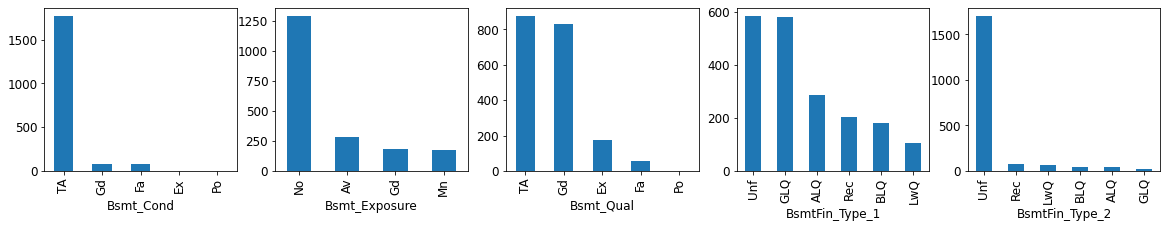

In [15]:
# NBVAL_IGNORE_OUTPUT

fig, axes = plt.subplots(1, 5, figsize=(20, 3))
training_data['Bsmt_Cond'].value_counts().plot.bar(ax=axes[0])
axes[0].set_xlabel('Bsmt_Cond')
training_data['Bsmt_Exposure'].value_counts().plot.bar(ax=axes[1])
axes[1].set_xlabel('Bsmt_Exposure')
training_data['Bsmt_Qual'].value_counts().plot.bar(ax=axes[2])
axes[2].set_xlabel('Bsmt_Qual')
training_data['BsmtFin_Type_1'].value_counts().plot.bar(ax=axes[3])
axes[3].set_xlabel('BsmtFin_Type_1')
training_data['BsmtFin_Type_2'].value_counts().plot.bar(ax=axes[4])
axes[4].set_xlabel('BsmtFin_Type_2')

<AxesSubplot:xlabel='BsmtFin_SF_1', ylabel='BsmtFin_SF_2'>

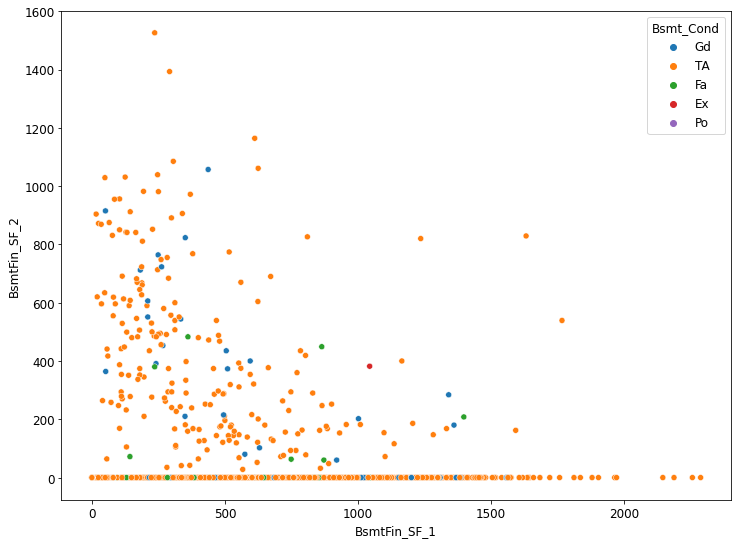

In [16]:
# NBVAL_IGNORE_OUTPUT

sns.scatterplot(data=training_data, x='BsmtFin_SF_1', y='BsmtFin_SF_2', hue='Bsmt_Cond')

Based on the visualizations above, we create the following function for computing the `basement_value` feature

In [17]:
def basement_value(pt):
    baths = pt['Bsmt_Full_Bath'] + 0.5 * pt['Bsmt_Half_Bath'] 
    large = pt['Total_Bsmt_SF'] > 300
    if pt['BsmtFin_Type_1'] in {'GLQ', 'ALQ'} and pt['Bsmt_Cond'] in {'Ex', 'Gd'} \
        and pt['Bsmt_Qual'] in {'Ex', 'Gd'} and baths > 0.5 and large:
        return 1
    return 0

In [18]:
training_data['basement_value'] = training_data.apply(basement_value, axis=1)
training_data = training_data.drop(basement_features, axis=1)

We would also like to add the categorical feature `Neighborhood`. 
To use it in the training data, we need to convert it into a numeric representation using [DictVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html)

In [19]:
from pandas.api.types import CategoricalDtype

from sklearn.feature_extraction import DictVectorizer

vec_enc = DictVectorizer()
vec_enc.fit(training_data[['Neighborhood']].to_dict(orient='records'))
Neighborhood_data = vec_enc.transform(training_data[['Neighborhood']].to_dict(orient='records')).toarray()
Neighborhood_cats = vec_enc.get_feature_names()
Neighborhood = pd.DataFrame(Neighborhood_data, columns=Neighborhood_cats)
Neighborhood = Neighborhood.drop(['Neighborhood=GrnHill', 'Neighborhood=Landmrk'], axis=1, errors='ignore')
training_data = pd.concat([training_data, Neighborhood], axis=1)
training_data = training_data.drop(columns=Neighborhood_cats[0])

Finally, we want to make sure that we only include the features we have created in this process and remove the others that we did not preprocess.

In [20]:
training_data= training_data.filter(
    regex="Neighborhood=.|Gr_Liv_Area|Garage_Area|SalePrice|LA_v_1st|1st_v_2nd|wd_v_2nd|basement_value"
)

At this point, we're satisfied with state of the training data and would like to save it to a CSV file so that it can be used for model training later.

In [21]:
!mkdir -p outputs
training_data.to_csv("outputs/cleaned_data_housing.csv", index=False)

# Saving data and code together

Oftentimes, we want to revisit how a training dataset was prepared. This requires tracking the code for generating the data alongside the data. We can do this automatically by registering the file as a `LineaArtifact` via `lineapy.save`. 

We can call `lineapy.save` directly on the `training_data` variable, in which case LineaPy will handle serialization of the variable automatically. 

In [22]:
artifact_lineapy_serialized = lineapy.save(training_data, "cleaned_data_housing_lineapy")

If we prefer to specify the serialization mechanism ourselves, as is the case in this example, we can instead call `lineapy.save` on the special variable `lineapy.file_system`, which refers to file system writes. In this case, it refers to the process of creating the cleaned_data_housing.csv file.

In [23]:
artifact = lineapy.save(lineapy.file_system, "cleaned_data_housing")

The code for creating the CSV file can be retrieved via the `get_code()` method on the artifact. Note that the code contains only the necessary and sufficient operations. That is, the code for EDA that does not transform the data is excluded from the artifact code, and the artifact code is sufficient to reproduce the results. From the entire notebook session, LineaPy is able to automatically extract the following code for producing the CSV file:

In [24]:
from lineapy.utils.utils import prettify
print(prettify(artifact.get_code()))

import pandas as pd

training_data = pd.read_csv("data/ames_train_cleaned.csv")
columns_to_drop = training_data.columns[
    training_data.isnull().sum() / training_data.shape[0] > 0.8
]
training_data = training_data.drop(columns_to_drop, axis=1)
import numpy as np

training_data["LA_v_1st"] = training_data["Lot_Area"] / training_data["1st_Flr_SF"]
training_data["1st_v_2nd"] = np.where(
    training_data["2nd_Flr_SF"] > 0,
    training_data["1st_Flr_SF"] / training_data["2nd_Flr_SF"],
    0,
)
training_data["wd_v_2nd"] = np.where(
    training_data["2nd_Flr_SF"] > 0,
    training_data["Wood_Deck_SF"] / training_data["2nd_Flr_SF"],
    0,
)
training_data = training_data.drop(["1st_Flr_SF", "2nd_Flr_SF"], axis=1)
basement_features = [x for x in training_data.columns if "bsmt" in x.lower()]


def basement_value(pt):
    baths = pt["Bsmt_Full_Bath"] + 0.5 * pt["Bsmt_Half_Bath"]
    large = pt["Total_Bsmt_SF"] > 300
    if (
        pt["BsmtFin_Type_1"] in {"GLQ", "ALQ"}
        and pt["Bsm

# Creating a data preprocessing pipeline

We can use LineaPy to create a data pipeline from an artifact with the `to_pipeline` function. We currently support Python scripts and Airflow as the two frameworks for running pipelines. Learn more about pipelines [here](https://docs.lineapy.org/en/latest/tutorials/00_api_basics.html#Using-artifacts-to-build-pipelines)

In [25]:
# NBVAL_SKIP
import os
directory = lineapy.to_pipeline([artifact.name], framework='AIRFLOW', output_dir = os.environ.get("AIRFLOW_HOME","~/airflow")+"/dags")

Pipeline source generated in the directory: /Users/dorx/airflow/dags

Generated python module cleaned_data_housing.py

Added Airflow DAG named cleaned_data_housing_dag. Start a run from the Airflow UI or CLI.

Generated Dockerfile cleaned_data_housing_Dockerfile

Generated requirements file cleaned_data_housing_requirements.txt

In [26]:
# NBVAL_SKIP
os.listdir(directory)

['data_housing_pipeline_requirements.txt',
 'cleaned_data_housing_Dockerfile',
 'cleaned_data_housing_requirements.txt',
 'data_housing_pipeline_Dockerfile',
 'cleaned_data_housing.py',
 'data_housing_pipeline.py',
 'cleaned_data_housing_dag.py',
 'data_housing_pipeline_dag.py']

In [27]:
# NBVAL_SKIP
os.system(f"cat {directory}/cleaned_data_housing_dag.py");

import os

import cleaned_data_housing
from airflow import DAG
from airflow.operators.python_operator import PythonOperator
from airflow.utils.dates import days_ago

default_dag_args = {"owner": "airflow", "retries": 2, "start_date": days_ago(1)}

dag = DAG(
    dag_id="cleaned_data_housing_dag",
    schedule_interval="*/15 * * * *",
    max_active_runs=1,
    catchup=False,
    default_args=default_dag_args,
)


cleaned_data_housing = PythonOperator(
    dag=dag,
    task_id="cleaned_data_housing_task",
    python_callable=cleaned_data_housing.cleaned_data_housing,
)
